In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from   IPython.display import display, HTML
from collections import deque
import random
import os
import sys
import pathlib
from collections import deque
from tqdm.notebook import tqdm, trange
import datetime
from scipy import interpolate
import math

import matplotlib.ticker as mtick
import matplotlib.dates as md

from IPython.display import clear_output

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
import gpytorch
import matplotlib.dates as md

In [2]:
parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)

In [3]:
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

In [4]:
def ema(series, periods, fillna=False):
    if fillna:
        return series.ewm(span=periods, min_periods=0).mean()
    return series.ewm(span=periods, min_periods=periods).mean()

def macd_signal(close, n_fast=12, n_slow=26, n_sign=9, fillna=False):
    """Moving Average Convergence Divergence (MACD Signal)
    Args:
        close(pandas.Series): dataset 'Close' column.
        n_fast(int): n period short-term.
        n_slow(int): n period long-term.
        n_sign(int): n period to signal.
        fillna(bool): if True, fill nan values.

    Returns:
        EMA of MACD: pandas.Series: New feature generated.
    """
    emafast = ema(close, n_fast, fillna)
    emaslow = ema(close, n_slow, fillna)
    macd = emafast - emaslow
    macd_signal = ema(macd, n_sign, fillna)
    
    macd_diff = macd - macd_signal
    if fillna:
        macd_signal = macd_signal.replace([np.inf, -np.inf], np.nan).fillna(0)
    return pd.Series(macd_diff, name='MACD_diff')

def get_LOB_features(LOB_data, trade_date, tick_size, imb_model, macd_model):
    # create features
    LOB_data['mid_price']   = (LOB_data['ask_1'] + LOB_data['bid_1'])/2
    LOB_features            = LOB_data[['mid_price']]/ 10000
    LOB_features['imbalance_1'] = (LOB_data['bid_volume_1'] - LOB_data['ask_volume_1'])/(LOB_data['bid_volume_1'] + LOB_data['ask_volume_1'])
    LOB_features['macd_120_260_90'] = macd_signal(LOB_features['mid_price'], n_fast=120, n_slow=260, n_sign=90, fillna=True)
    LOB_features['timestamp'] = [datetime.datetime.strptime(trade_date, '%Y-%m-%d') + datetime.timedelta(seconds=i) for i in LOB_features.index]    

    # create predictors
    unique_index_values = LOB_features['macd_120_260_90'].round(4).unique()
    for unique_value in unique_index_values:
        if unique_value not in macd_model.index:
            macd_model.loc[unique_value,:] = np.nan
    macd_model2 = macd_model.sort_index().fillna(method='ffill').fillna(method='bfill')  

    nb_trades_ahead, fwd_price_move_w = 100, 'fwd_price_move_100'
    LOB_features['imbalance_signal'] = (imb_model.loc[LOB_features['imbalance_1'].round(2), fwd_price_move_w].values*tick_size/nb_trades_ahead)*len(LOB_features)

    nb_trades_ahead, fwd_price_move_w = 20000, 'fwd_price_move_20000'
    LOB_features['macd_1_signal'] = (macd_model2.loc[LOB_features['macd_120_260_90'].round(4), fwd_price_move_w].values*tick_size/nb_trades_ahead)*len(LOB_features)

    nb_trades_ahead, fwd_price_move_w = 500, 'fwd_price_move_500'
    LOB_features['macd_2_signal'] = (macd_model2.loc[LOB_features['macd_120_260_90'].round(4), fwd_price_move_w].values*tick_size/nb_trades_ahead)*len(LOB_features)
    
    timeofday = ((LOB_features.timestamp.astype('datetime64[%s]' % 'h') - \
                LOB_features.timestamp.astype('datetime64[%s]' % 'D')).values/3600000000000).astype(float) + \
                (((LOB_features.timestamp.astype('datetime64[%s]' % 'm')-\
                 LOB_features.timestamp.astype('datetime64[%s]' % 'h')).values/60000000000).astype(float)/60).round(1)
    LOB_features['time_of_day'] = timeofday
    
    return LOB_features

In [5]:
def get_LOB_data(data_path, asset_name, trade_date):
    LOB_data_path = os.path.join(data_path, asset_name, f'{asset_name}_{trade_date}_34200000_57600000_orderbook_5.csv')
    LOB_data      = pd.read_csv(LOB_data_path,
                                usecols   = [0, 1, 2, 3],
                                engine    = 'python',
                                index_col = None,
                                header    = None,
                                infer_datetime_format = True)

    LOB_messages = pd.read_csv(f'{data_path}/{asset_name}/{asset_name}_{trade_date}_34200000_57600000_message_5.csv', 
                               usecols   = [0],
                               engine    = 'python',
                               index_col = 0,
                               header    = None)
    LOB_data.index = LOB_messages.index
    LOB_data.columns = [f'ask_1', f'ask_volume_1', f'bid_1', f'bid_volume_1']
    LOB_data.index.name = 'time'
    LOB_data = LOB_data.reset_index(drop=False).groupby('time').last()
    
    return LOB_data

In [6]:
imb_model = pd.read_pickle('../nb_trading/imb_model.pkl')
macd_model = pd.read_pickle('../nb_trading/macd_model.pkl')

# Load Data & Signals

In [7]:
from AOE.utils import get_meta_order_df, verbose_print #get_LOB_features #get_LOB_data
from AOE.plots import rescale_plot
from AOE.plots import hit_ratio_analysis, reward_distribution_analysis, regret_plots, analyze_meta_order

In [8]:
# data_path     = pathlib.Path(os.path.abspath(os.path.join('..')), "data", "Market")
reward_path   = pathlib.Path(os.path.abspath(os.path.join('..')), "data", "Rewards")
feature_path  = pathlib.Path(os.path.abspath(os.path.join('..')), "data", "Features")

asset_name    = "MSFT"
tick_size     = 0.01

In [9]:
all_data = {}

for filename in os.listdir(feature_path):
    f = os.path.join(feature_path,filename)
    if 'features' in f:
        if os.path.isfile(f):
            trade_date = f.split('_')[2].split('.')[0]
            # print('Reading: ', trade_date)
            LOB_features = pd.read_pickle(f)
            LOB_features = LOB_features.set_index('timestamp')
            all_data[trade_date] = LOB_features

# Optimal Strategies & Trading parameters

In [10]:
strategies  = {'imbalance' : {'name'             : 'imbalance',
                              'params'           : {'feature_name'     : 'imbalance_signal',
                                                      'estimation_period': '1min',
                                                      'use_interpolator' : False,
                                                      'alpha'            : 10, 
                                                      'phi'              : 0.005, 
                                                      'kappa'            : 5e-7},
                                'contextual_params': {'feature_name'  : 'time_of_day'}},
               
               'macd1' : {'name'             : 'imbalance',
                            'params'           : {'feature_name'     : 'macd_1_signal',
                                                  'estimation_period': '1min', 
                                                  'use_interpolator' : False,
                                                  'alpha'            : 10, 
                                                  'phi'              : 0.005, 
                                                  'kappa'            : 3e-9},
                            'contextual_params': {'feature_name'  : 'time_of_day'}},
               
               'macd2'        : {'name'             : 'imbalance',
                                'params'           : {'feature_name'     : 'macd_2_signal',
                                                      'estimation_period': '1min', 
                                                      'use_interpolator' : False,
                                                      'alpha'            : 10, 
                                                      'phi'              : 0.005, 
                                                      'kappa'            : 3e-9},
                                'contextual_params': {'feature_name'  : 'time_of_day'}}}

In [11]:
arrival_intensity   = 0.0005 # in trade time
meta_order_size     = 100 # Fixed size of every order
latency             = 0   # TODO: implement this
T                   = 60*10 # trading window for every order in seconds
trading_frequency   = 3  # in seconds

# GP bandits

In [12]:
from AOE.gp_bandit import gp_bandit, gp_bandit_finance

In [13]:
# Likelihood models & non stationarity params
likelihood              = gpytorch.likelihoods.GaussianLikelihood()
size_buffer             = 20 # in terms of number of rewards to sample from
size_buffer_nts         = 60*10 # in terms of seconds of oobservation
nb_intermediary_rewards = 2

# Bandit objects
bandits = {'TS'  : gp_bandit_finance(strategies, bandit_algo='TS', likelihood=likelihood, size_buffer=size_buffer), 
           'UCB' : gp_bandit_finance(strategies, bandit_algo='UCB', likelihood=likelihood, size_buffer=size_buffer, bandit_params=0.1) }

# Other control parameters and variables

In [17]:
# variables for historical bandit data
pending_rewards           = {bandit_k: {} for bandit_k in bandits.keys() }
pending_int_rewards       = {bandit_k: {} for bandit_k in bandits.keys() }
pending_rewards['oracle'] = {}
historical_rewards        = {bandit_k: [] for bandit_k in bandits.keys() }
historical_strats         = {bandit_k: [] for bandit_k in bandits.keys() }
historical_oracle_rewards = []
historical_oracle_strats  = []
historical_all_rewards    = []
historical_reward_times   = []
order_arrival_times       = []

# variables for historical trading data
tape_meta_orders          = deque(maxlen=None) # A tape with meta order objects
meta_order_id_c           = 0 # counter to flag meta orders with IDs
order_id_c                = 0 # counter to flag orders with IDs

i_order                   = 0
nb_added_rewards          = {bandit_k:0 for bandit_k in bandits.keys()}
tape_meta_orders          = deque(maxlen=None)

In [18]:
if False:
    order_arrival_times = []
    for trade_date in all_data.keys():
        order_arrival_times += list(all_data[trade_date].index)

    order_arrival_times = np.sort(np.array(order_arrival_times))
else:
    order_arrival_times = pd.read_pickle('order_arrival_times.pkl')

In [19]:
verbose_level       = 1

# Trading simulation

In [20]:
from AOE.order import order
from AOE.meta_order import meta_order
from AOE.strategy import strategy

from AOE.stats import get_meta_order_df
from AOE.stats import get_meta_order_details
from AOE.plots import plot_meta_order

from AOE.optimal_trading import execute_strategy
from AOE.bandit_utils import update_reward_variables, update_bandit_variables, fake_update_bandit_variables
from AOE.bandit_utils import pop_from_dict, execute_and_obtain_rewards, update_pending_rewards


*******  2021-06-14 13:10:34.833049  *******
I received an order at 2021-06-14 13:10:34.833049 with quantity -100
Selecting strategies ...
Selected strategies: {'TS': 'imbalance', 'UCB': 'imbalance'}
execution and generating orders
Executed strategy imbalance between 2021-06-14 13:10:34.833049 and 2021-06-14T13:20:34.738910000
Intermediary rewards: ['2021-06-14T13:14:49.275335000:-1.4103426272888982e-14   ']
Final reward: 0.00056212444272315
execution and generating orders
Executed strategy macd1 between 2021-06-14 13:10:34.833049 and 2021-06-14T13:20:34.738910000
Intermediary rewards: ['2021-06-14T13:12:58.674554000:-0.02271758092655251   ']
Final reward: -0.03219616204693765
execution and generating orders
Executed strategy macd2 between 2021-06-14 13:10:34.833049 and 2021-06-14T13:20:34.738910000
Intermediary rewards: ['2021-06-14T13:15:50.042888000:-0.03870905214190432   ']
Final reward: -0.024830393487119497
Oracle strategy: imbalance
Adding an oracle reward obtained at 2021-06-1

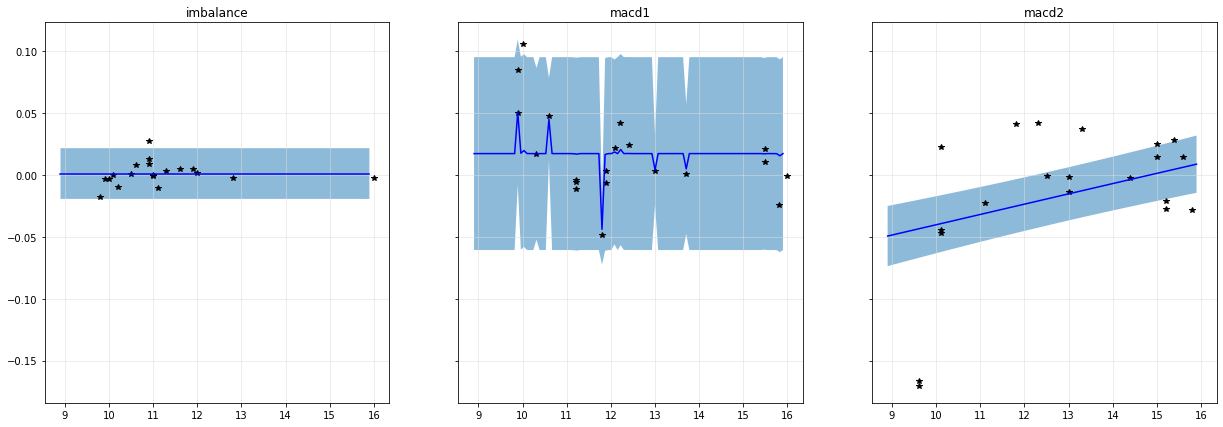

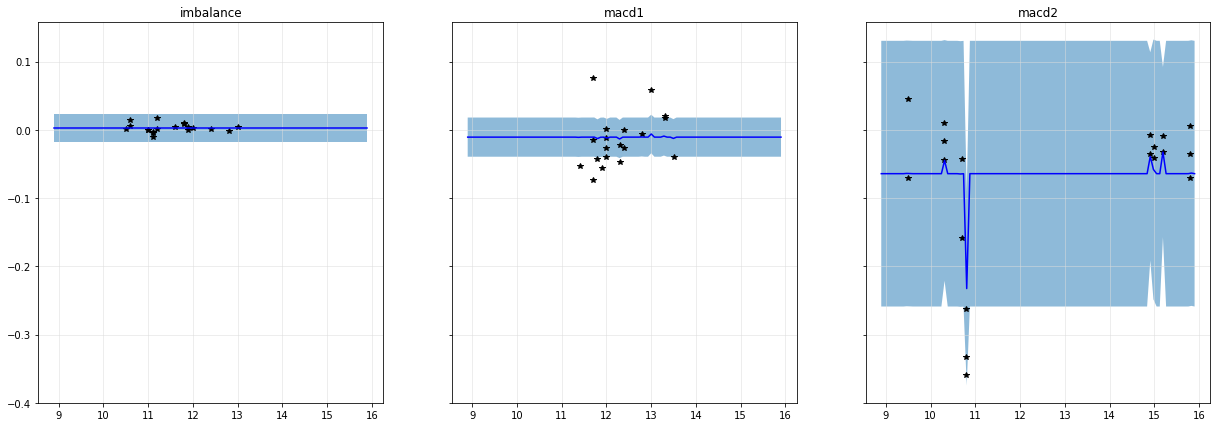


*******  2021-06-14 13:13:00.372622  *******
Adding a final reward for bandit TS obtained at 2021-06-14T13:13:00.372622000

*******  2021-06-14 13:13:00.372622  *******
Adding a final reward for bandit UCB obtained at 2021-06-14T13:13:00.372622000
Adding an oracle reward obtained at 2021-06-14T13:13:08.097263000
Adding strats rewards obtained at 2021-06-14T13:13:08.097263000


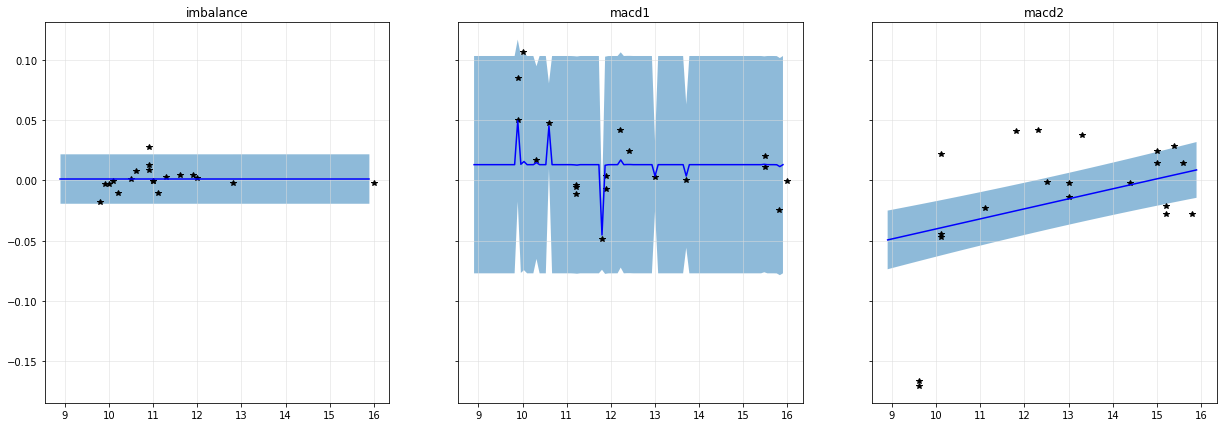

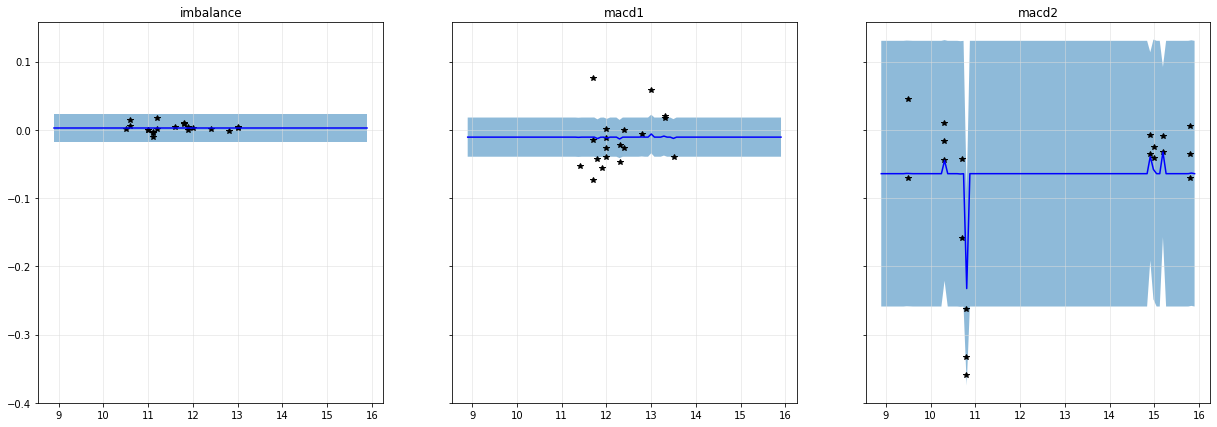


*******  2021-06-14 13:13:08.097263  *******
Adding a final reward for bandit TS obtained at 2021-06-14T13:13:08.097263000

*******  2021-06-14 13:13:08.097263  *******
Adding a final reward for bandit UCB obtained at 2021-06-14T13:13:08.097263000

*******  2021-06-14 13:14:49.275335  *******
Adding an intermediate reward for bandit TS obtained at 2021-06-14T13:14:49.275335000

*******  2021-06-14 13:14:49.275335  *******
Adding an intermediate reward for bandit UCB obtained at 2021-06-14T13:14:49.275335000

*******  2021-06-14 13:19:22.533153  *******
I received an order at 2021-06-14 13:19:22.533153 with quantity 100
Selecting strategies ...
Selected strategies: {'TS': 'macd1', 'UCB': 'imbalance'}
execution and generating orders
Executed strategy imbalance between 2021-06-14 13:19:22.533153 and 2021-06-14T13:29:21.804943000
Intermediary rewards: ['2021-06-14T13:23:29.776938000:-0.0013946731234889377   ']
Final reward: -0.001898305084766058
execution and generating orders
Executed st

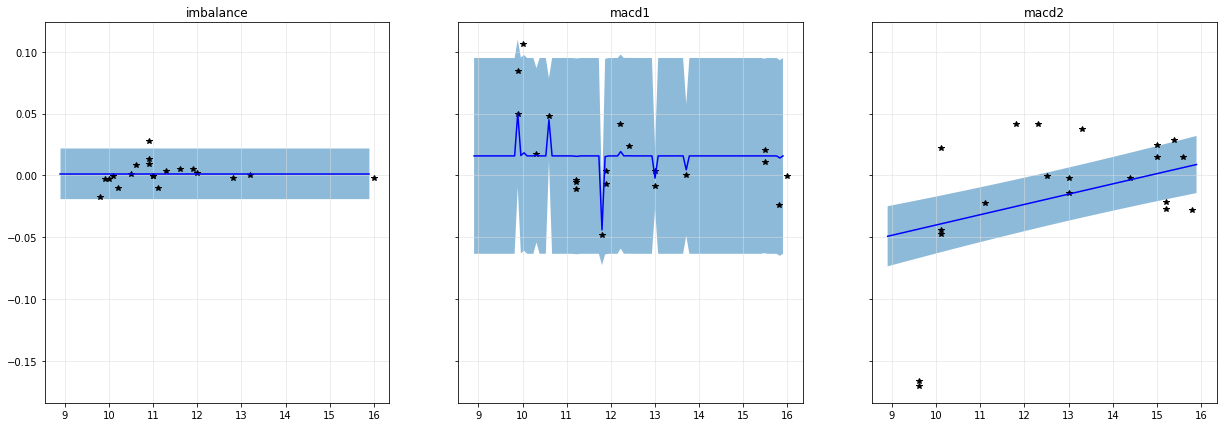

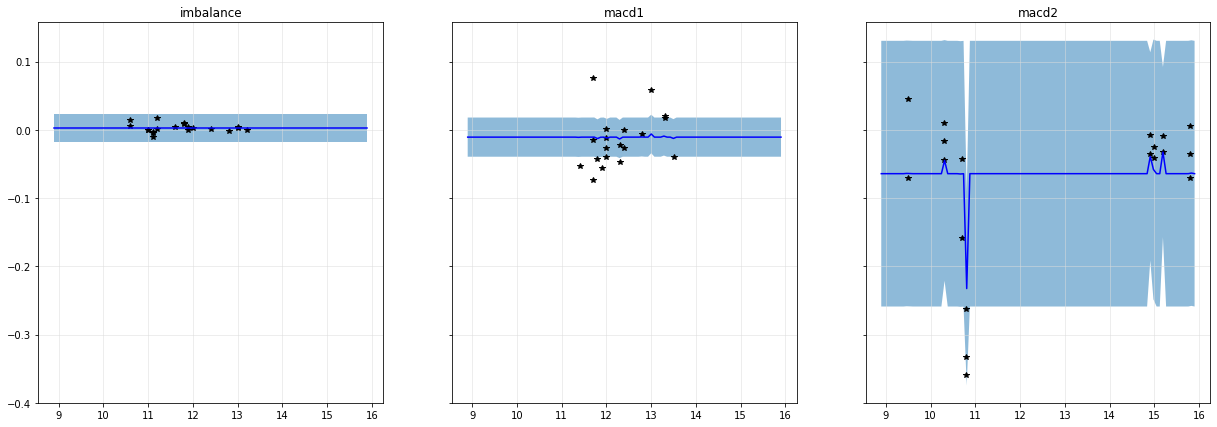


*******  2021-06-14 13:20:34.738910  *******
Adding a final reward for bandit TS obtained at 2021-06-14T13:20:34.738910000

*******  2021-06-14 13:20:34.738910  *******
Adding a final reward for bandit UCB obtained at 2021-06-14T13:20:34.738910000

*******  2021-06-14 13:21:27.110139  *******
Adding an intermediate reward for bandit TS obtained at 2021-06-14T13:21:27.110139000

*******  2021-06-14 13:23:29.776938  *******
Adding an intermediate reward for bandit UCB obtained at 2021-06-14T13:23:29.776938000

*******  2021-06-14 13:23:47.952893  *******
I received an order at 2021-06-14 13:23:47.952893 with quantity -100
Selecting strategies ...
Selected strategies: {'TS': 'macd1', 'UCB': 'imbalance'}
execution and generating orders
Executed strategy imbalance between 2021-06-14 13:23:47.952893 and 2021-06-14T13:33:47.847205000
Intermediary rewards: ['2021-06-14T13:28:00.540806000:0.0008909031046019538   ']
Final reward: 0.0013169871981666662
execution and generating orders
Executed st

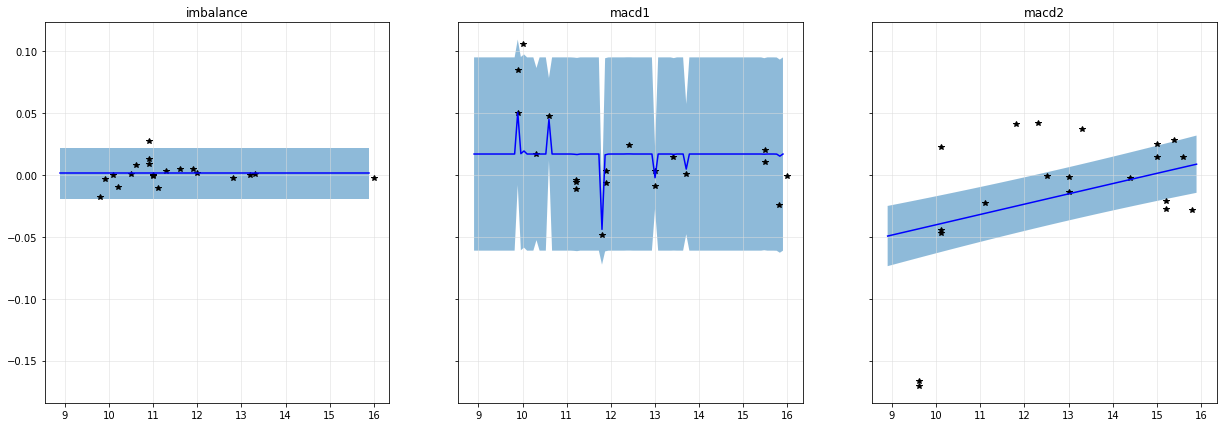

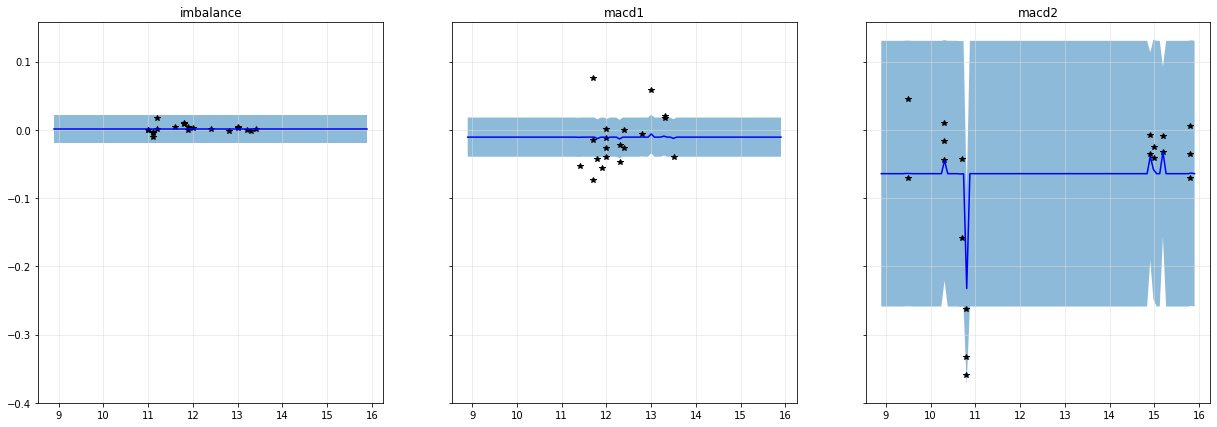


*******  2021-06-14 13:29:21.804943  *******
Adding a final reward for bandit TS obtained at 2021-06-14T13:29:21.804943000

*******  2021-06-14 13:29:21.804943  *******
Adding a final reward for bandit UCB obtained at 2021-06-14T13:29:21.804943000
Adding an oracle reward obtained at 2021-06-14T13:30:05.276312000
Adding strats rewards obtained at 2021-06-14T13:30:05.276312000


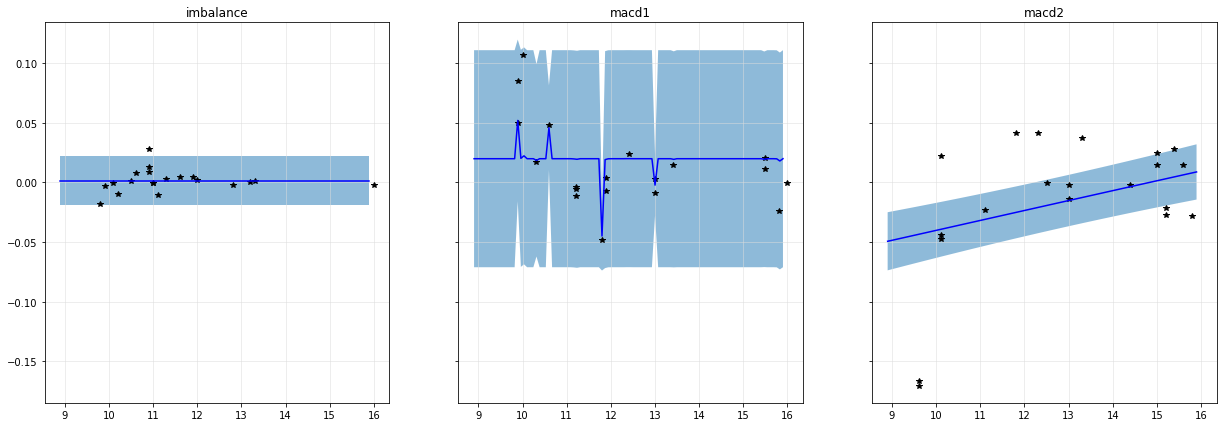

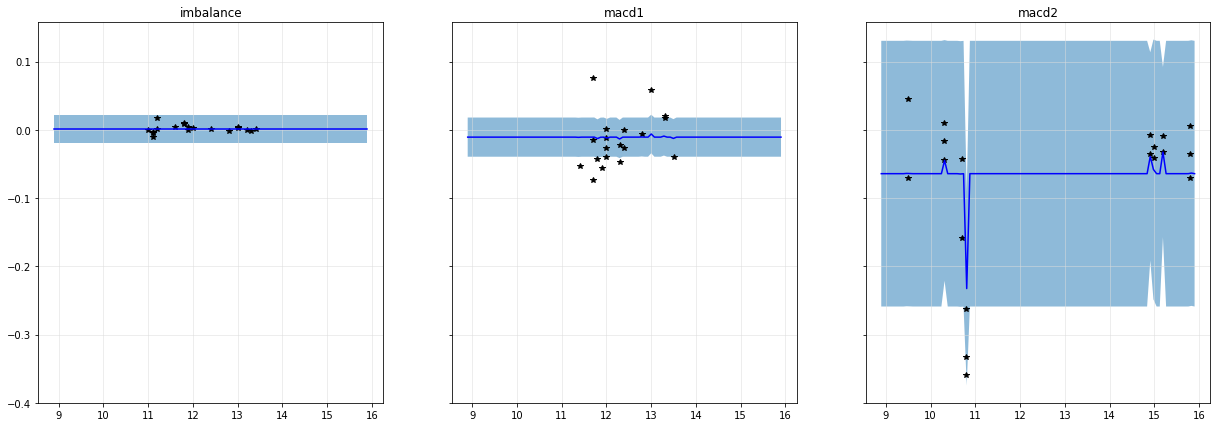


*******  2021-06-14 13:30:05.276312  *******
Adding a final reward for bandit TS obtained at 2021-06-14T13:30:05.276312000

*******  2021-06-14 13:30:05.276312  *******
Adding a final reward for bandit UCB obtained at 2021-06-14T13:30:05.276312000

*******  2021-06-14 13:31:39.831010  *******
Adding an intermediate reward for bandit TS obtained at 2021-06-14T13:31:39.831010000

*******  2021-06-14 13:31:39.831010  *******
Adding an intermediate reward for bandit UCB obtained at 2021-06-14T13:31:39.831010000
Adding an oracle reward obtained at 2021-06-14T13:33:47.847205000
Adding strats rewards obtained at 2021-06-14T13:33:47.847205000


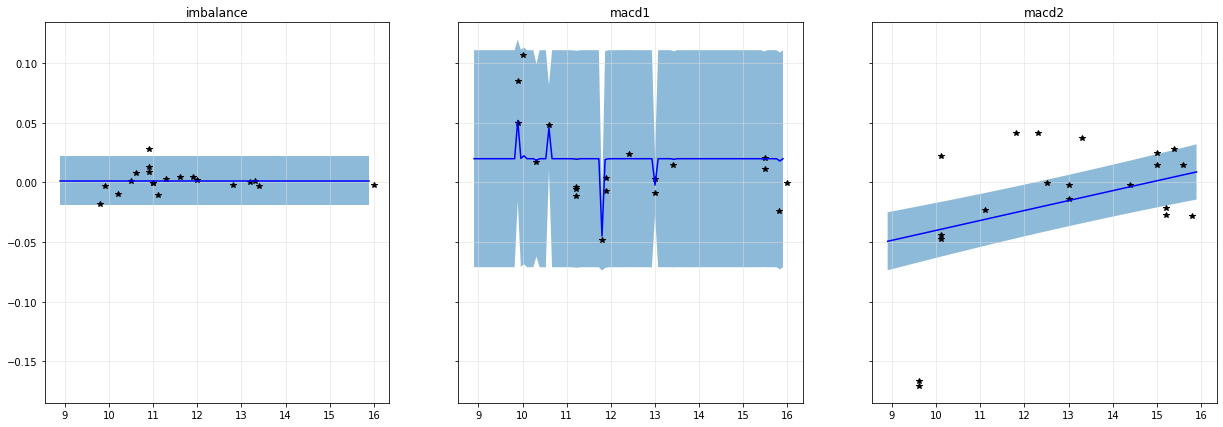

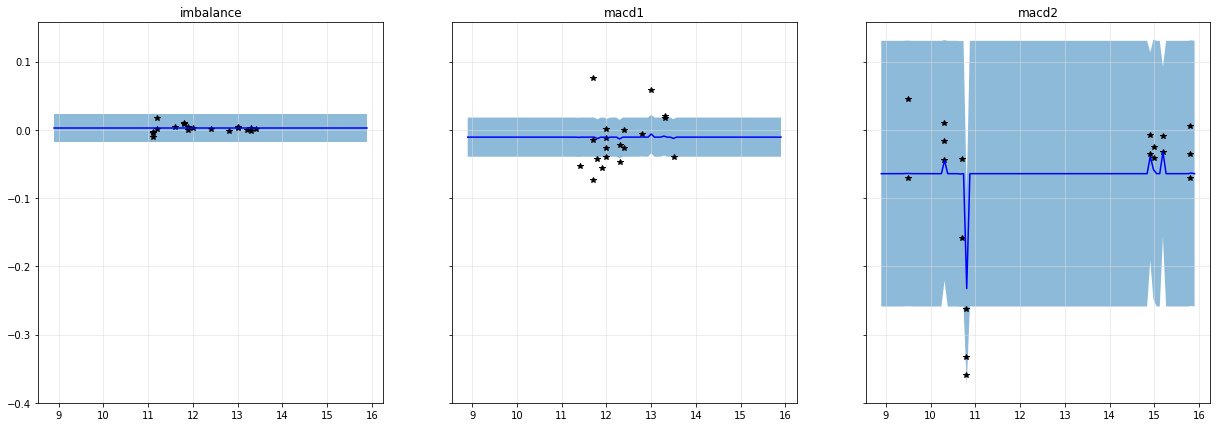


*******  2021-06-14 13:33:47.847205  *******
Adding a final reward for bandit TS obtained at 2021-06-14T13:33:47.847205000

*******  2021-06-14 13:33:47.847205  *******
Adding a final reward for bandit UCB obtained at 2021-06-14T13:33:47.847205000

*******  2021-06-14 13:37:31.430563  *******
I received an order at 2021-06-14 13:37:31.430563 with quantity 100
Selecting strategies ...
Selected strategies: {'TS': 'macd1', 'UCB': 'imbalance'}
execution and generating orders
Executed strategy imbalance between 2021-06-14 13:37:31.430563 and 2021-06-14T13:47:30.517075000
Intermediary rewards: ['2021-06-14T13:41:49.279185000:-0.004899682392127267   ']
Final reward: -0.00627469207530645
execution and generating orders
Executed strategy macd1 between 2021-06-14 13:37:31.430563 and 2021-06-14T13:47:30.517075000
Intermediary rewards: ['2021-06-14T13:39:53.316227000:-0.01892090789368318   ']
Final reward: -0.0198892245720401
execution and generating orders
Executed strategy macd2 between 2021-06

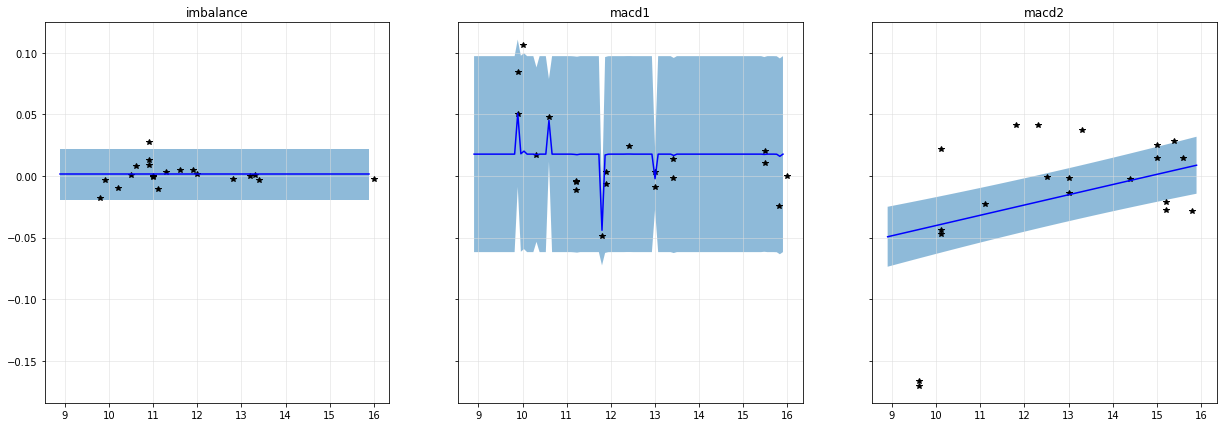

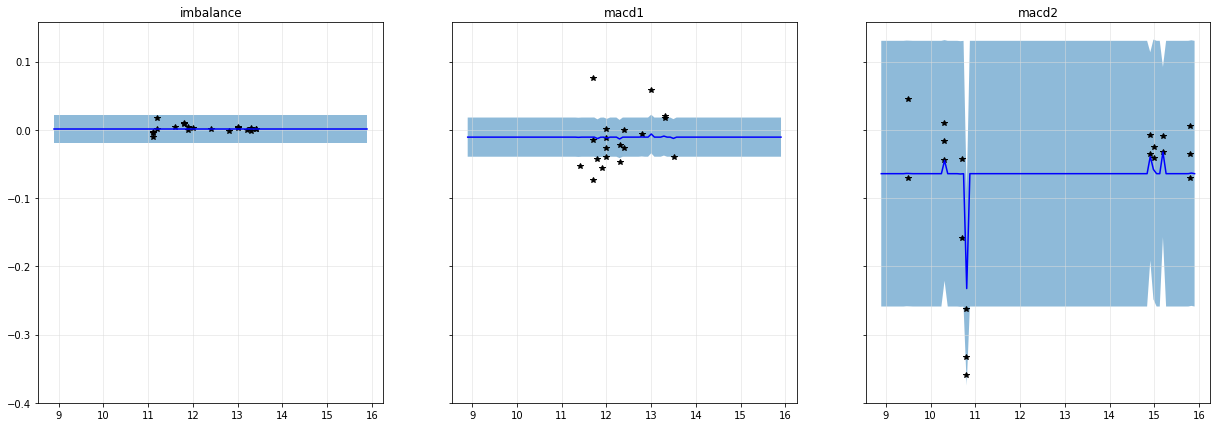


*******  2021-06-14 13:37:42.058715  *******
Adding a final reward for bandit TS obtained at 2021-06-14T13:37:42.058715000

*******  2021-06-14 13:37:42.058715  *******
Adding a final reward for bandit UCB obtained at 2021-06-14T13:37:42.058715000

*******  2021-06-14 13:39:53.316227  *******
Adding an intermediate reward for bandit TS obtained at 2021-06-14T13:39:53.316227000

*******  2021-06-14 13:41:49.279185  *******
Adding an intermediate reward for bandit UCB obtained at 2021-06-14T13:41:49.279185000
Adding an oracle reward obtained at 2021-06-14T13:47:30.517075000
Adding strats rewards obtained at 2021-06-14T13:47:30.517075000


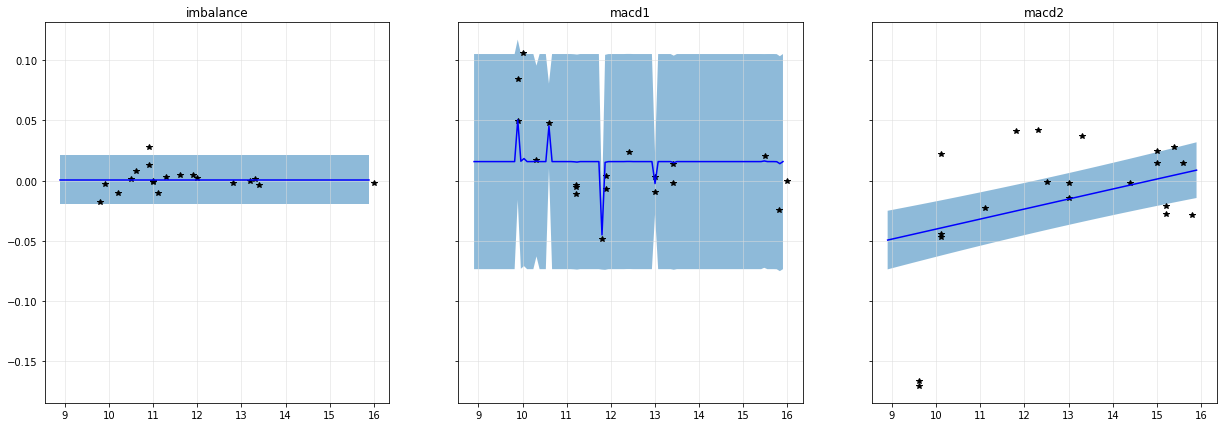

KeyboardInterrupt: 

In [21]:
true_arrival_time_indices = np.random.poisson(arrival_intensity, size=len(order_arrival_times))

i_reward_added = 0

for (i_time, order_arrival_time) in enumerate(order_arrival_times): # leave a few minutes
    trade_date = str(order_arrival_time).split(' ')[0]
    
    ###############################################
    # retrain GPs hyperparameters every N orders 
    ###############################################
    retrain_hyperparameters = True
    # if i_order%10    == 0: 
    #     retrain_hyperparameters=True
    
    ##################################################
    # add pending delayed rewards to bandit objects
    ##################################################
    to_pops = update_reward_variables(order_arrival_time, 
                                      historical_oracle_rewards, historical_oracle_strats, 
                                      historical_all_rewards, historical_reward_times,
                                      pending_rewards, verbose_level)
    
    if len(historical_all_rewards) > i_reward_added:
        i_reward_added = len(historical_all_rewards)
        bandits['TS'].plot_strategies(lv=8.9, uv=15.9)
        bandits['UCB'].plot_strategies(lv=8.9, uv=15.9)
    
    # Sanity check
    if len(historical_rewards['TS'])!=len(historical_rewards['UCB']):
        print('Intentional error !!')
        fdff+1
    
    pop_from_dict(pending_rewards['oracle'], to_pops)
    
    for bandit_k in bandits.keys():
        to_pops_int, to_pops = update_bandit_variables(pending_int_rewards, pending_rewards, bandits, bandit_k, 
                                                       order_arrival_time, 
                                                       verbose_level,
                                                       retrain_hyperparameters, historical_rewards, historical_strats,
                                                       nb_added_rewards)
        pop_from_dict(pending_rewards[bandit_k], to_pops)
        pop_from_dict(pending_int_rewards[bandit_k], to_pops_int)
        

    ##################################################
    # if an order arrives: add intermediary
    # and final rewards to pending list
    ##################################################
    if true_arrival_time_indices[i_time]>0:
        # randomize buys and sells
        buysell = 2*np.random.randint(0, 2, size=None, dtype=int)-1
        
        verbose_print(verbose_level, order_arrival_time, f'I received an order at {order_arrival_time} with quantity {buysell*meta_order_size}', True)
        i_order          += 1
        
        ######################
        # get feature values
        ######################
        feature_values = all_data[trade_date].loc[order_arrival_time:].iloc[0,:].fillna(0.) # fillna should be controlled here ..
        
        ######################################
        # select the strategy for all bandits
        ######################################
        verbose_print(verbose_level, order_arrival_time, f'Selecting strategies ...')
        
        best_strategies_bandits = {}
        for bandit_k in bandits.keys():
            best_strategies_bandits[bandit_k]  = random.choice(list(strategies.keys()))
            
            if nb_added_rewards[bandit_k] < 5: # at least 5 rewards before sampling
                best_strategies_bandits[bandit_k]  = random.choice(list(strategies.keys()))
            else:
                best_strategies_bandits[bandit_k]  = bandits[bandit_k].select_best_strategy(feature_values)
        
        verbose_print(verbose_level, order_arrival_time, f'Selected strategies: {best_strategies_bandits}')
        
        ######################################
        # Execute all available strategies 
        ######################################
        order_id_c, meta_order_id_c, reward_info, all_strats_rewards, \
        best_oracle_reward, best_oracle_strategy = execute_and_obtain_rewards(tape_meta_orders, order_id_c, meta_order_id_c, strategies, 
                                                                              all_data[trade_date], order_arrival_time, 
                                                                              T, trading_frequency, buysell*meta_order_size, 
                                                                              latency, trade_date, verbose_level, nb_intermediary_rewards, tick_size)

        ######################################
        # add intermediary and final rewards of
        # selected strategies of bandits
        ######################################
        update_pending_rewards(pending_int_rewards, pending_rewards, 
                               bandits, best_strategies_bandits, reward_info, 
                               feature_values, strategies,
                               best_oracle_strategy, best_oracle_reward, order_arrival_time, all_strats_rewards)

        
        verbose_print(verbose_level, order_arrival_time, f"Oracle strategy: {best_oracle_strategy}")
    
    if i_order%10   == 0: 
        clear_output(wait=True)

In [ ]:
# reward_info

# Regret analysis

In [64]:
# get historical rewards and regret
rewards_to_plot = pd.DataFrame(index=historical_reward_times)
regrets_to_plot = pd.DataFrame(index=historical_reward_times)

for bandit_k in bandits.keys():
    regrets_to_plot[bandit_k] = - np.array(historical_rewards[bandit_k]) + np.array(historical_oracle_rewards)
for (i_strat, strat) in enumerate(strategies.keys()):
    regrets_to_plot[strat]    = - np.array(historical_all_rewards)[:,i_strat] + np.array(historical_oracle_rewards)

for bandit_k in bandits.keys():
    rewards_to_plot[bandit_k] = np.array(historical_rewards[bandit_k])
for (i_strat, strat) in enumerate(strategies.keys()):
    rewards_to_plot[strat]    = np.array(historical_all_rewards)[:,i_strat] 

regrets_to_plot = regrets_to_plot.sort_index()
rewards_to_plot = rewards_to_plot.sort_index()

### Hit ratio

Global number of rewards for every bandit: 503
Hit ratio TS: 31 %
Hit ratio UCB: 35 %


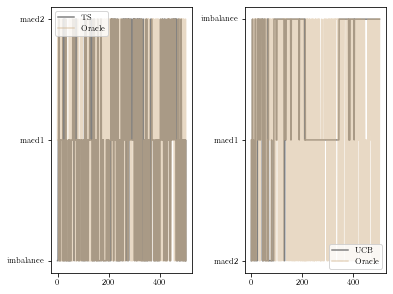

In [65]:
hit_ratio_analysis(historical_strats, bandits, historical_oracle_strats, _W = 5.5)

### Reward distributions

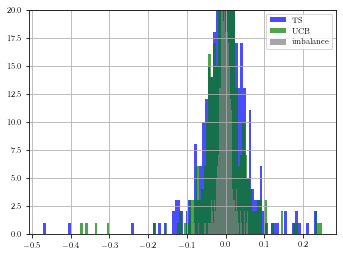

In [67]:
rewards_to_plot.TS.hist(bins=100, color='b', alpha=0.7)
rewards_to_plot.UCB.hist(bins=100, color='g', alpha=0.7)
rewards_to_plot.imbalance.hist(bins=100, color='grey', alpha=0.7)

plt.ylim(0, 20)
plt.legend(['TS', 'UCB', 'imbalance'])

### Reward distributions in time

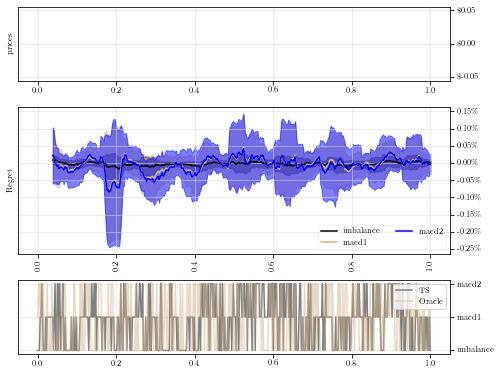

In [68]:
period_est  = 20 # in number of rewards, can be "10min"
bandit_name = 'TS'

reward_distribution_analysis(bandit_name, bandits, period_est, LOB_features, rewards_to_plot, historical_reward_times, 
                               historical_strats, historical_oracle_strats, strategies, W = 7, figure_name = None)

### Regret plots

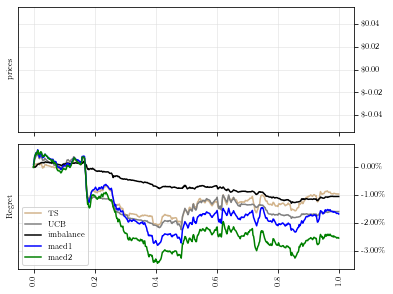

In [86]:
regret_plots(strategies, historical_reward_times, rewards_to_plot, LOB_features, bandits, W=5.5, figure_name = None)

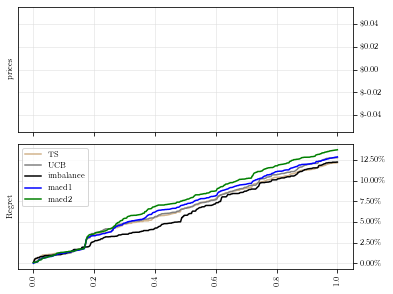

In [88]:
regret_plots(strategies, historical_reward_times, regrets_to_plot, LOB_features, bandits, W=5.5, figure_name = None)

### Analyze a given specific order

Feature name : macd_1_signal
Strategy type: imbalance
Initial Inventory: 100


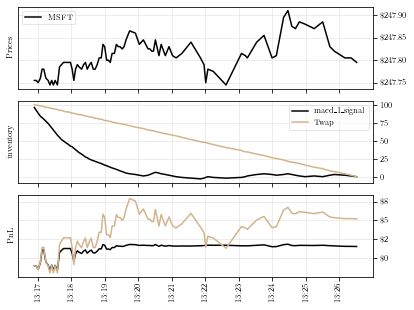

In [89]:
meta_order_id = 64
analyze_meta_order(meta_order_id, tape_meta_orders, W=5.8, figure_name = None)

### GP plot

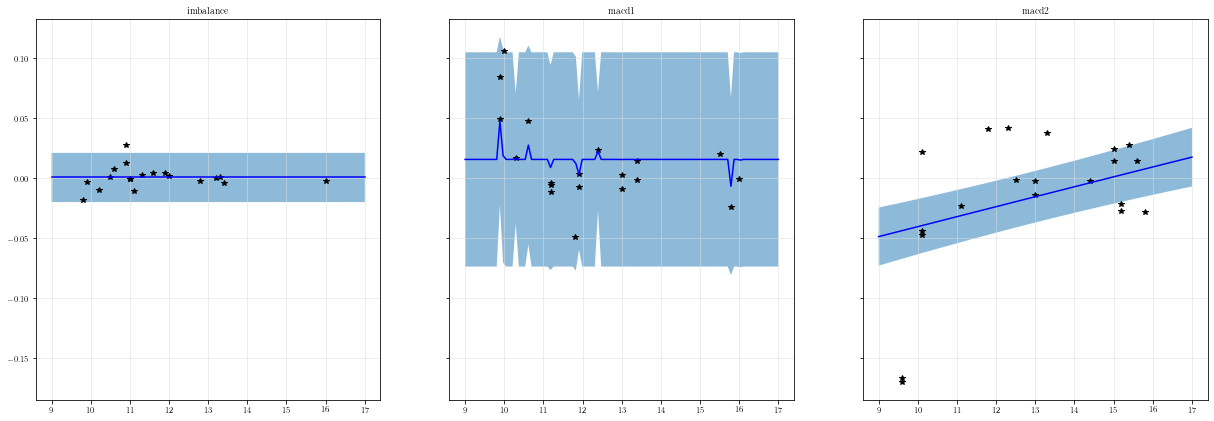

In [90]:
bandit_name  = 'TS'
bandits[bandit_name].plot_strategies(lv=9, uv=17)

In [91]:
rewards_to_plot['trade_date']         = [str(s).split(' ')[0] for s in rewards_to_plot.index]
rewards_to_plot['order_arrival_time'] = rewards_to_plot.index - np.timedelta64(60*10,'s')

In [92]:
feature_columns = all_data[list(all_data.keys())[0]].columns
for col_ in feature_columns:
    rewards_to_plot[col_] = np.nan

In [93]:
for key_ in all_data.keys():
    tmp_rewards = rewards_to_plot[ rewards_to_plot.trade_date==key_]

    rewards_to_plot.loc[tmp_rewards.index, 'order_arrival_time'] = \
                [all_data[key_].index[np.argmin(np.abs(all_data[key_].index - \
                tmp_rewards['order_arrival_time'].iloc[j]))] for j in range(len(tmp_rewards))  ]

    rewards_to_plot.loc[tmp_rewards.index, feature_columns] = all_data[key_].loc[tmp_rewards.index, :]

In [94]:
rewards_to_plot['hour_of_day'] = rewards_to_plot['time_of_day'].round()

In [95]:
# rewards_to_plot.groupby("hour_of_day").mean().macd1.plot()

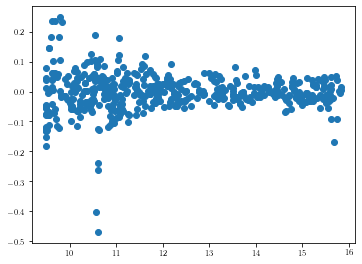

In [96]:
reward_features = rewards_to_plot.set_index('order_arrival_time')
plt.scatter(reward_features.index.hour+reward_features.index.minute/60, 
            rewards_to_plot.macd1)

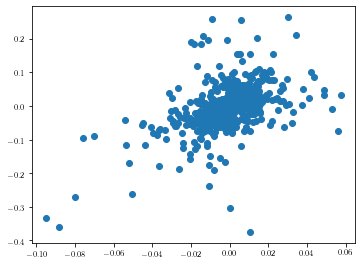

In [98]:
reward_features = rewards_to_plot.set_index('order_arrival_time')
plt.scatter(reward_features.imbalance, 
            rewards_to_plot.macd2)

In [107]:
# reward_features

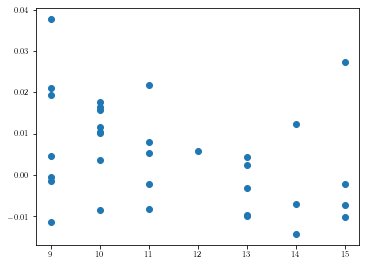

In [104]:
reward_features = rewards_to_plot.set_index('order_arrival_time')
reward_features = reward_features.loc['2021-06-01', :]

# 
plt.scatter(reward_features.index.hour+reward_features.index.minute/60, 
            reward_features.imbalance)

<AxesSubplot:xlabel='time_of_day'>

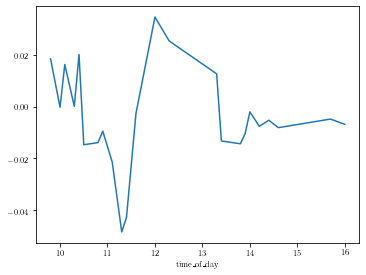

In [113]:
reward_features.groupby("time_of_day").mean().rolling(3).mean().TS.plot()

In [122]:
meta_order_id = 50

feature_name  = tape_meta_orders[meta_order_id].strategy.feature_name
strategy_name = tape_meta_orders[meta_order_id].strategy.strategy_name
trade_date    = str(tape_meta_orders[meta_order_id].t0).split('T')[0]

print('Feature name      :', feature_name)
print('Strategy type     :', strategy_name)
print('Initial Inventory :', tape_meta_orders[meta_order_id].initial_inventory)
print('Trade date        :', trade_date)

Feature name      : macd_2_signal
Strategy type     : imbalance
Initial Inventory : -100
Trade date        : 2021-06-01 11:25:07.099186


In [123]:
order_df   = get_meta_order_details(tape_meta_orders[meta_order_id], trade_date)

In [124]:
order_df

,quantity,execution_price,execution_time,meta_order_inventory,meta_order_cash,meta_order_pnl,TWAP_inventory,TWAP_quantity,TWAP_cash,TWAP_pnl
order_id,,,,,,,,,,
6412,8,248.595,2021-06-01 11:25:10.212004,-92,-1988.760,-2.000,-100,0.0,-0.000,-2.000
12925,6,248.555,2021-06-01 11:25:13.379739,-86,-3480.090,1.680,-99,1.0,-248.555,2.000
19439,3,248.535,2021-06-01 11:25:16.383005,-83,-4225.695,3.400,-99,0.0,-248.555,3.980
25954,3,248.535,2021-06-01 11:25:19.824970,-80,-4971.300,3.400,-98,1.0,-497.090,3.980
32470,2,248.515,2021-06-01 11:25:22.894632,-78,-5468.330,5.000,-98,0.0,-497.090,5.940
...,...,...,...,...,...,...,...,...,...,...
967895,-1,248.475,2021-06-01 11:34:50.953714,6,-26341.445,6.905,-2,1.0,-24348.805,11.745
974554,-1,248.445,2021-06-01 11:34:54.173593,5,-26093.000,6.725,-2,0.0,-24348.805,11.805
981214,-1,248.420,2021-06-01 11:34:57.430477,4,-25844.580,6.600,-1,1.0,-24597.225,11.855
